<a href="https://colab.research.google.com/github/faithrts/COMP-551/blob/faith-branch-testing/A1_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [186]:
### importing libraries and setting the random seed

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import math
import bisect
from scipy.stats import zscore
from scipy.io import arff
from importlib import reload

from sklearn import preprocessing
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor

np.random.seed(1234)

# Data Handling

## Importing

In [187]:
### importing the files from the web to google colab

# hepatitis.data
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data

# messidor_features.arff
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff

--2022-10-06 19:39:29--  http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7545 (7.4K) [application/x-httpd-php]
Saving to: ‘hepatitis.data’

hepatitis.data      100%[===================>]   7.37K  --.-KB/s    in 0s      

2022-10-06 19:39:29 (276 MB/s) - ‘hepatitis.data’ saved [7545/7545]

--2022-10-06 19:39:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117224 (114K) [application/x-httpd-php]
Saving to: ‘messidor_features.arff’

messidor_features.a 100%[===================>] 114.48K   5

## Preprocessing

### Helper functions

In [188]:
def imputation(df, bool_col, non_bool_col):
  copy_df = df.copy()

  # saves a copy of the dataframe without rows that include '?' values
  intact_rows = copy_df[~copy_df.eq('?').any(axis=1)].astype('float')

  # iterates through columns with boolean values
  for col in bool_col:

    # replaces instances of 1.0 and 2.0 with the boolean integers 0 and 1
    intact_rows[col] = intact_rows[col].replace({1.0:0, 2.0:1})
    # calculates the mode of the current column (ignores '?')
    mode = int(intact_rows[col].mode()[0])

    # in the original dataframe, replaces each '?' with the column's mode
    copy_df[col] = copy_df[col].replace({'?': mode}).astype('int64')
    # in the original dataframe, replaces 1.0 and 2.0 with boolean ints 0 and 1
    copy_df[col] = copy_df[col].replace({1.0:0, 2.0:1})

  # iterates through columns with non-boolean values
  for col in non_bool_col:
    # calculates the mean of the current column (ignores '?')
    mean = intact_rows[col].mean()
    # in the original dataframe, replaces each '?' with the column's mean
    copy_df[col] = copy_df[col].replace({'?': mean}).astype('float')
    
  return copy_df

In [189]:
### computes zcore to remove outlier data
def remove_outliers(df):
  abs_z_scores = np.abs(df.apply(zscore))

  # a boolean array that returns True at index i if the row
  # i in df does not contain any values with a zscore greater
  # than 3
  instance_bool_arr = (abs_z_scores < 3).all(axis = 1)
  return df[instance_bool_arr]

In [190]:
# normalizes an input array
def normalize_array(arr):
  normalized_array = []

  for i in arr:
    new_val = (i - min(arr)) / (max(arr) - min(arr))
    normalized_array.append(new_val)

  return normalized_array

# normalizes columns in input dataframe df; 
# assumes last column is the target labels
def normalize_df(df):
  normalized_df = df.copy()

  for col in normalized_df.iloc[:, :-1]:
    normalized_col = normalize_array(df[col])
    normalized_df[col] = normalized_col

  return normalized_df

In [191]:
# standardizes columns in input dataframe df;
# assumes last column is the target labels
def standardize_df(df):
  standardized_df = df.copy()

  # iterates through each column, excluding the last column
  for col in standardized_df.iloc[:, :-1]:

    # calculates mean value and standard deviation of column
    mean_val = standardized_df[col].mean()
    standard_dev = standardized_df[col].std()

    # standardizes the values in the current column
    standardized_df[col] = (standardized_df[col] - mean_val) / standard_dev

  return standardized_df

In [192]:
# counts items in a given range
def count_in_ranges(item_arr, range_arr, bins = 10):
  count_arr = np.zeros(len(range_arr))

  for item in item_arr:
    pos = bisect.bisect_left(range_arr, item)
    count_arr[pos] += 1

  return count_arr

# creates histograms for each column in input dataframe df and array of columns
# column_arr
def create_histograms(df, column_arr = 0, n_cols = 3):
  # if no array of column names given, creates histograms for all columns
  if column_arr == 0:
    column_arr = list(df)

  # the number of rows
  n_rows = math.ceil(len(column_arr)/n_cols)

  # setting up a figure
  fig = plt.figure(figsize = (15, 9), tight_layout = True)

  # setting up space for graphs
  gs = gridspec.GridSpec(n_rows, n_cols)

  # setting current column and row numbers
  cur_col, cur_row = 0, 0

  # iterates through each column name
  for col in column_arr:
    min = math.floor(df[col].min())
    max = math.ceil(df[col].max())
    mean = df[col].mean()
    
    range_arr = np.linspace(min, max + 1, 100)
    count_arr = count_in_ranges(df[col].to_numpy(), range_arr)

    if cur_col == n_cols:
      cur_col = 0
      cur_row += 1

    # plots histogram
    ax = fig.add_subplot(gs[cur_row, cur_col])
    ax.autoscale(True)
    ax.bar(count_arr, range_arr)
    ax.set_title(col.upper())
    ax.set_xlabel("Occurrence count")
    ax.set_ylabel("Value")
    ax.axhline(y = mean, color = 'r', linestyle = '-', label = "Mean = " + str(round(mean, 2)))
    ax.legend(loc = "upper right")
    
    cur_col += 1

  plt.show()

In [193]:
# function to split the data;
# assumes the last column of the df is the target label
# and percentage_train is an integer out of 100
def train_test_split(df, percentage_train = 66):
  # makes a copy of the input df
  copy_df = df.copy()

  # shuffling the order of rows in the input dataframe
  copy_df = copy_df.sample(frac = 1, random_state = 1)

  # splits the input dataframe into arrays of instances and labels
  x, y = copy_df.iloc[:, :-1].to_numpy(), copy_df.iloc[:, -1].to_numpy()

  # the number of data points
  instance_count = x.shape[0]

  # the number of instances to be used in the training data
  train_count = int(instance_count * (percentage_train / 100))

  # splitting the data into training data and labels,
  # and testing data and labels
  x_train, y_train = x[:train_count], y[:train_count]
  x_test, y_test = x[train_count:], y[train_count:]

  return x_train, x_test, y_train, y_test

In [207]:
# random forest for feature importance on a regression problem;
# assumes the first column is target labels
def RF_find_features(df):
  # splitting the data in the input dataframe df
  x_train, x_test, y_train, y_test = train_test_split(df)

  # define the model
  model = RandomForestRegressor()

  # fit the model
  model.fit(x_train, y_train)

  # the value at index i is the feature importance of the
  # feature at column i in the dataframe
  importance_arr = model.feature_importances_

  # summarize feature importance
  for i in range(len(importance_arr)):
      print('Feature: %s, Score: %.5f' % (list(df.columns)[i], importance_arr[i]))

  return importance_arr

def plot_feature_importance(importance_arr):
  plt.bar([x for x in range(len(importance_arr))], importance_arr)
  plt.title("Feature importance")
  plt.xlabel("Feature index in data")
  plt.ylabel("Score")
  plt.show

In [195]:
# prints the top 2 features in an importance array
def top_2_features(importance_arr, df):
  top_feat_value = max(importance_arr)
  top_feat_index = importance_arr.tolist().index(top_feat_value)

  second_feat_value = np.max([val for index, val in enumerate(importance_arr) if index != top_feat_index])
  second_feat_index = importance_arr.tolist().index(second_feat_value)

  print("The most important feature is " + list(df.columns)[top_feat_index])
  print("The second most important feature is " + list(df.columns)[second_feat_index])

In [196]:
# plots the distributions of boolean feature values
def plot_bool_distributions(column_arr, df, n_cols = 3):
  # the number of rows
  n_rows = math.ceil(len(column_arr)/n_cols)

  # setting up a figure
  fig = plt.figure(figsize = (15, 9), tight_layout = True)

  # setting up space for graphs
  gs = gridspec.GridSpec(n_rows, n_cols)

  # setting current column and row numbers
  cur_col, cur_row = 0, 0
  
  for col in column_arr:
    x_arr = ['True', 'False']
    y_arr = np.bincount(df[col].to_numpy())

    if cur_col == n_cols:
      cur_col = 0
      cur_row += 1

    # plots histogram
    ax = fig.add_subplot(gs[cur_row, cur_col])
    ax.autoscale(True)
    ax.bar(x_arr, y_arr)
    ax.set_title(col.upper())
    ax.set_xlabel("Value")
    ax.set_ylabel("Instance count")

    bar_num = 0

    ''' Faith is currently working on this
    for bar in ax.patches:
      percentage = round((y_arr[bar_num]/y_arr.sum()), 2) * 100

      w = bar.get_width()
      h = bar.get_height()
      x, y = bar.get_xy()
      plt.text(x + w/2, y + h*1.01, str(percentage) + '%', ha = 'center', weight = 'bold')
      
      bar_num += 1'''

    cur_col += 1

  plt.show()

### Loading and cleaning hepatitis.data

In [197]:
### creating the dataframe for hepatitis.data

# creates a dataframe from the .data file
hep_df = pd.read_csv("hepatitis.data", sep=",", header=None)

# the column names
hep_cols = ['CLASS', 'AGE', 'SEX', 'STEROID','ANTIVIRALS', 'FATIGUE',
            'MALAISE', 'ANOREXIA', 'LIVER BIG', 'LIVER FIRM',
            'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES',
            'BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'ALBUMIN',
            'PROTIME', 'HISTOLOGY']

# adds the column names to the dataframe
hep_df.columns = hep_cols

In [198]:
### creating lists to separate the names of columns containing
### boolean values vs the ones containing continuous values

bool_col = ['CLASS', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE',
            'MALAISE', 'ANOREXIA', 'LIVER BIG', 'LIVER FIRM',
            'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES',
            'HISTOLOGY']

non_bool_col = ['AGE', 'BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']

In [199]:
### cleaning hepatitis dataframe

# moves the target "CLASS" column to the end of the dataframe
class_col = hep_df.pop('CLASS')
hep_df['CLASS'] = class_col

# saves a copy of the dataframe cleaned through imputation
hep_imp_df = imputation(hep_df, bool_col, non_bool_col)

# removes all rows with ?
hep_df = hep_df[~hep_df.eq('?').any(axis=1)].astype('float')

# maps all 1.0 values to 0 and all 2.0 values to 1
for col in bool_col:
  hep_df[col] = hep_df[col].replace({1.0:0, 2.0:1}).astype('int')

# uses zscore to remove outliers (rows with values above 3 standard
# deviations beyond the respective column means)
hep_df = remove_outliers(hep_df)

In [200]:
hep_imp_df

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,CLASS
0,30.0,1,0,1,1,1,1,0,1,1,1,1,1,1.0,85.0000,18.0,4.0,62.5125,0,1
1,50.0,0,0,1,0,1,1,0,1,1,1,1,1,0.9,135.0000,42.0,3.5,62.5125,0,1
2,78.0,0,1,1,0,1,1,1,1,1,1,1,1,0.7,96.0000,32.0,4.0,62.5125,0,1
3,31.0,0,0,0,1,1,1,1,1,1,1,1,1,0.7,46.0000,52.0,4.0,80.0000,0,1
4,34.0,0,1,1,1,1,1,1,1,1,1,1,1,1.0,102.9125,200.0,4.0,62.5125,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,46.0,0,1,1,0,0,0,1,1,1,0,0,0,7.6,102.9125,242.0,3.3,50.0000,1,0
151,44.0,0,1,1,0,1,1,1,0,1,1,1,1,0.9,126.0000,142.0,4.3,62.5125,1,1
152,61.0,0,0,1,0,0,1,0,0,1,0,1,1,0.8,75.0000,20.0,4.1,62.5125,1,1
153,53.0,1,0,1,0,1,1,1,1,0,0,1,0,1.5,81.0000,19.0,4.1,48.0000,1,1


In [201]:
hep_df

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,CLASS
5,34.0,0,1,1,1,1,1,1,1,1,1,1,1,0.9,95.0,28.0,4.0,75.0,0,1
10,39.0,0,0,0,1,1,1,0,0,1,1,1,1,1.3,78.0,30.0,4.4,85.0,0,1
11,32.0,0,1,0,0,1,1,1,0,1,0,1,1,1.0,59.0,249.0,3.7,54.0,0,1
12,41.0,0,1,0,0,1,1,1,0,1,1,1,1,0.9,81.0,60.0,3.9,52.0,0,1
13,30.0,0,1,1,0,1,1,1,0,1,1,1,1,2.2,57.0,144.0,4.9,78.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,45.0,0,1,0,1,1,1,1,1,1,1,1,1,1.3,85.0,44.0,4.2,85.0,1,1
143,49.0,0,0,1,0,0,1,1,1,0,0,1,1,1.4,85.0,70.0,3.5,35.0,1,0
145,31.0,0,0,1,0,1,1,1,1,1,1,1,1,1.2,75.0,173.0,4.2,54.0,1,1
153,53.0,1,0,1,0,1,1,1,1,0,0,1,0,1.5,81.0,19.0,4.1,48.0,1,1


In [202]:
### saving train/test splits for different versions of hepatitis data

# for the whole hepatitis dataframe
x_train_hep, x_test_hep, y_train_hep, y_test_hep = train_test_split(hep_df)

# for the hepatitis dataframe cleaned through imputation
x_train_hep_imp, x_test_hep_imp, y_train_hep_imp, y_test_hep_imp = train_test_split(hep_imp_df)

### Analysis of Hepatitis data

In [203]:
### finding the most correlated features with CLASS column (target)

# creates correlation dataframe
correlation_df = hep_df.corr()

# isolates for the CLASS column of the correlation dataframe and removes
# the CLASS row
class_correlation = (correlation_df).iloc[:-1, -1:]

# finds the 3 largest values (the 3 features most positively 
# correlated with CLASS)
pos_correlation = class_correlation.nlargest(3, 'CLASS')

# show the 3 features most positively correlated with target labels
pos_correlation.head()

,CLASS
ALBUMIN,0.393190
ASCITES,0.367521
PROTIME,0.328634


In [204]:
# finds the 3 smallest values (the 3 features most negatively
# correlated with CLASS)
neg_correlation = class_correlation.nsmallest(3, 'CLASS')

# show the 3 features most negatively correlated with target labels
neg_correlation.head()

,CLASS
HISTOLOGY,-0.463524
LIVER BIG,-0.171780
AGE,-0.165716


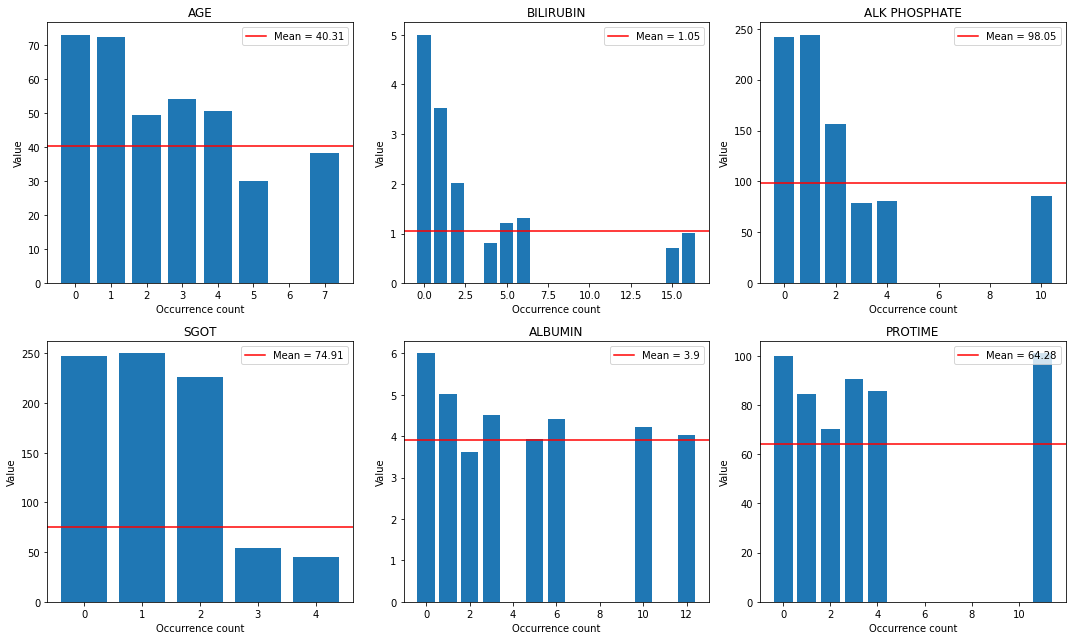

In [205]:
# outputs histograms (but with occurrence count along the x-axis)
# of the non-boolean columns
create_histograms(hep_df, non_bool_col, 3)

Feature: AGE, Score: 0.06765
Feature: SEX, Score: 0.00832
Feature: STEROID, Score: 0.00557
Feature: ANTIVIRALS, Score: 0.00000
Feature: FATIGUE, Score: 0.00111
Feature: MALAISE, Score: 0.01034
Feature: ANOREXIA, Score: 0.01889
Feature: LIVER BIG, Score: 0.00328
Feature: LIVER FIRM, Score: 0.00000
Feature: SPLEEN PALPABLE, Score: 0.01275
Feature: SPIDERS, Score: 0.00502
Feature: ASCITES, Score: 0.01745
Feature: VARICES, Score: 0.01640
Feature: BILIRUBIN, Score: 0.13715
Feature: ALK PHOSPHATE, Score: 0.11083
Feature: SGOT, Score: 0.04029
Feature: ALBUMIN, Score: 0.10264
Feature: PROTIME, Score: 0.35439
Feature: HISTOLOGY, Score: 0.08791


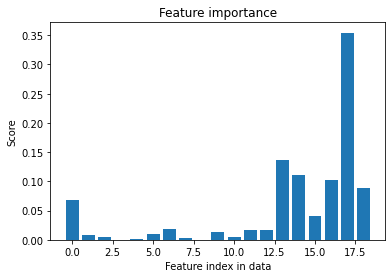

In [208]:
### using random forest to determine the relative feature importance

hep_importance_arr = RF_find_features(hep_df)

# plots the feature importance
plot_feature_importance(hep_importance_arr)

In [209]:
### finding the top 2 most important features to confirm values in correlation dataframe

top_2_features(hep_importance_arr, hep_df)

The most important feature is PROTIME
The second most important feature is BILIRUBIN


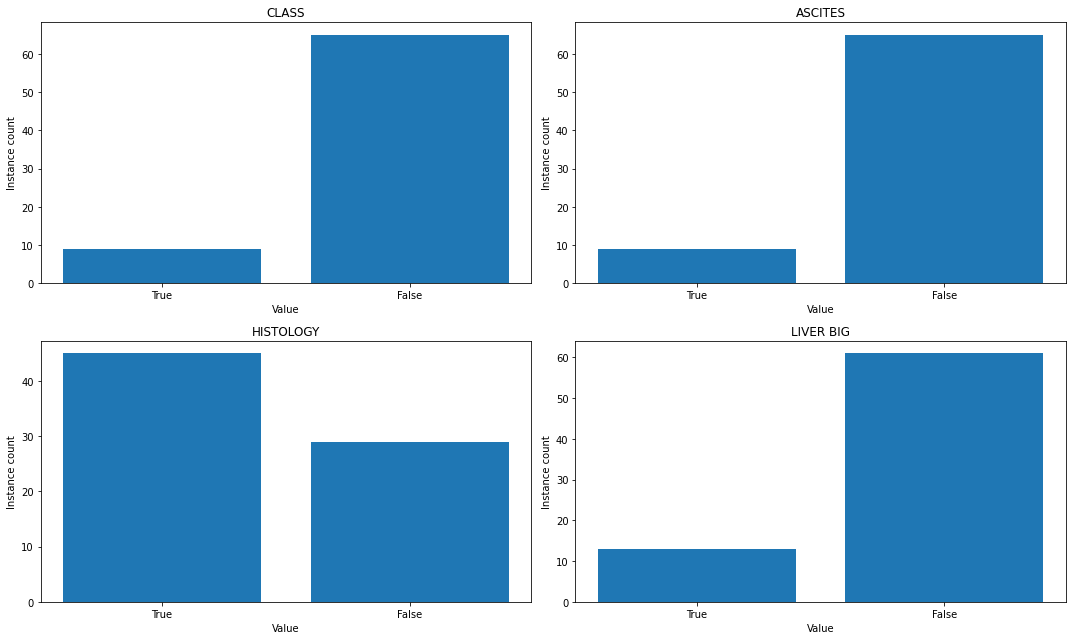

In [210]:
### analysis of boolean distributions for CLASS, ASCITES, HISTOLOGY, LIVER BIG

bool_cols_of_interest = ['CLASS', 'ASCITES', 'HISTOLOGY', 'LIVER BIG']

# plotting a bar graph for each boolean column of interest
plot_bool_distributions(bool_cols_of_interest, hep_df, 2)

### Loading and cleaning messidor.arff

In [211]:
### creating the dataframe for messidor_features.arff

# loads in the arff data
mess_data = arff.loadarff('messidor_features.arff')
# creates a dataframe from the .arff file
mess_df = pd.DataFrame(mess_data[0])

# the column names
mess_cols = ['QUALITY ASSESSMENT', 'PRE-SCREENING', 'MA DETECTION CL 0.5',
            'MA DETECTION CL 0.58','MA DETECTION CL 0.66', 'MA DETECTION CL 0.75',
            'MA DETECTION CL 0.83','MA DETECTION CL 0.91', 'MA DETECTION CL 1.0',
            'EXUDATES CL 0.5', 'EXUDATES CL 0.58','EXUDATES CL 0.66',
            'EXUDATES CL 0.75', 'EXUDATES CL 0.83','EXUDATES CL 0.91',
            'EXUDATES CL 1.0', 'MACULA-OPTIC DISC DISTANCE', 'OPTIC DISC DIAMATER', 
            'AM/FM CLASSIFICATION', 'CLASS']

# adds the column names to the dataframe
mess_df.columns = mess_cols

In [212]:
### cleaning the data in mess_df; there's no missing data so no imputation

# resaving the boolean values in the Class column from objects to ints
mess_df['CLASS'] = mess_df['CLASS'].map({b'0':0, b'1':1})

# columns with boolean values
mess_bool_cols = ['QUALITY ASSESSMENT', 'PRE-SCREENING', 'AM/FM CLASSIFICATION', 'CLASS']

# ensures the columns with boolean values save as integers
for col in mess_bool_cols:
  mess_df[col] = mess_df[col].astype('int64')

mess_df = remove_outliers(mess_df)

In [213]:
mess_df

,QUALITY ASSESSMENT,PRE-SCREENING,MA DETECTION CL 0.5,MA DETECTION CL 0.58,MA DETECTION CL 0.66,MA DETECTION CL 0.75,MA DETECTION CL 0.83,MA DETECTION CL 0.91,MA DETECTION CL 1.0,EXUDATES CL 0.5,EXUDATES CL 0.58,EXUDATES CL 0.66,EXUDATES CL 0.75,EXUDATES CL 0.83,EXUDATES CL 0.91,EXUDATES CL 1.0,MACULA-OPTIC DISC DISTANCE,OPTIC DISC DIAMATER,AM/FM CLASSIFICATION,CLASS
0,1,1,22.0,22.0,22.0,19.0,18.0,14.0,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24.0,24.0,22.0,18.0,16.0,13.0,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62.0,60.0,59.0,54.0,47.0,33.0,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55.0,53.0,53.0,50.0,43.0,31.0,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44.0,44.0,44.0,41.0,39.0,27.0,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,1,1,35.0,34.0,33.0,33.0,33.0,26.0,2.579859,0.001552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.537551,0.124181,0,0
1146,1,1,34.0,34.0,34.0,33.0,31.0,24.0,6.071765,0.937472,0.031145,0.003115,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0,0
1147,1,1,49.0,49.0,49.0,49.0,45.0,37.0,63.197145,27.377668,8.067688,0.979548,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0,0
1149,1,1,39.0,36.0,29.0,23.0,13.0,7.0,40.525739,12.604947,4.740919,1.077570,0.563518,0.326860,0.239568,0.174584,0.485972,0.106690,1,1


In [214]:
# creating the training and testing data and labels for the messidor dataframe
x_train_mess, x_test_mess, y_train_mess, y_test_mess = train_test_split(mess_df)

### Analysis of Messidor Features

In [215]:
### finding the most correlated features with Class column (target)

# creates correlation dataframe
correlation_df = mess_df.corr()

# removes the first row of the correlation dataframe
class_correlation = (correlation_df).iloc[:-1, -1:]

# finds the 3 largest values (the 3 features most positively 
# correlated with CLASS)
pos_correlation = class_correlation.nlargest(3, 'CLASS')

# show the 3 features most positively correlated with target labels
pos_correlation.head()

,CLASS
MA DETECTION CL 0.5,0.282618
MA DETECTION CL 0.58,0.254831
MA DETECTION CL 0.66,0.224684


In [216]:
# finds the 3 smallest values (the 3 features most negatively
# correlated with CLASS)
neg_correlation = class_correlation.nsmallest(3, 'CLASS')

# show the 3 features most negatively correlated with target labels
neg_correlation.head()

,CLASS
EXUDATES CL 0.5,-0.064864
EXUDATES CL 0.58,-0.030217
AM/FM CLASSIFICATION,-0.023560


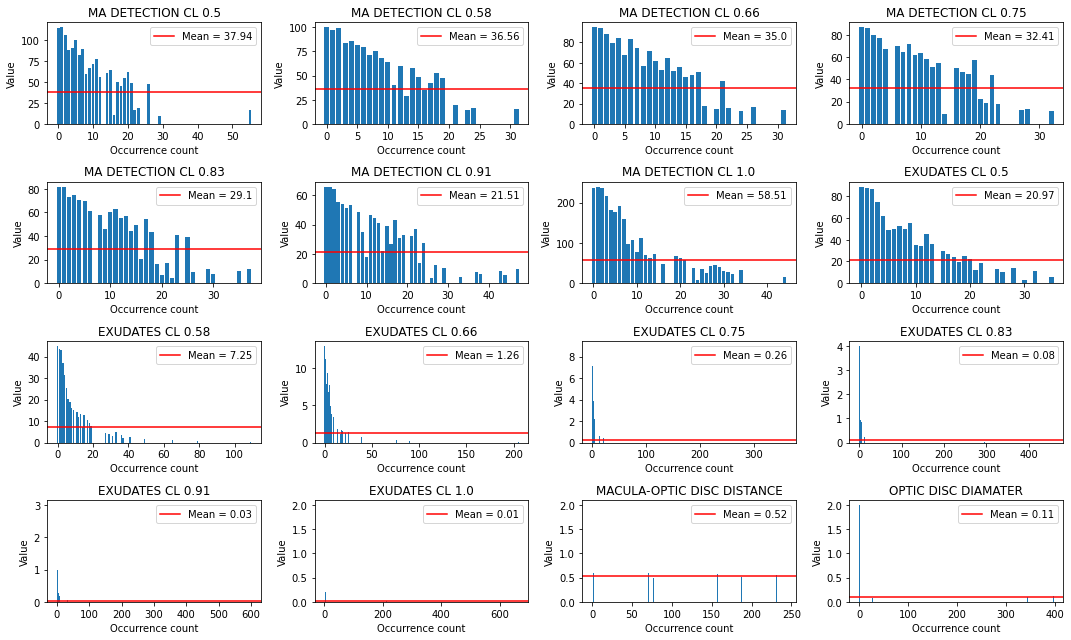

In [217]:
### creating histograms for each non-boolean valued column

create_histograms(mess_df, list(mess_df)[2:18], 4)

Feature: QUALITY ASSESSMENT, Score: 0.00000
Feature: PRE-SCREENING, Score: 0.00000
Feature: MA DETECTION CL 0.5, Score: 0.13718
Feature: MA DETECTION CL 0.58, Score: 0.02393
Feature: MA DETECTION CL 0.66, Score: 0.02420
Feature: MA DETECTION CL 0.75, Score: 0.03096
Feature: MA DETECTION CL 0.83, Score: 0.03345
Feature: MA DETECTION CL 0.91, Score: 0.04525
Feature: MA DETECTION CL 1.0, Score: 0.09298
Feature: EXUDATES CL 0.5, Score: 0.08353
Feature: EXUDATES CL 0.58, Score: 0.07630
Feature: EXUDATES CL 0.66, Score: 0.08076
Feature: EXUDATES CL 0.75, Score: 0.04197
Feature: EXUDATES CL 0.83, Score: 0.03122
Feature: EXUDATES CL 0.91, Score: 0.08038
Feature: EXUDATES CL 1.0, Score: 0.02757
Feature: MACULA-OPTIC DISC DISTANCE, Score: 0.08817
Feature: OPTIC DISC DIAMATER, Score: 0.09479
Feature: AM/FM CLASSIFICATION, Score: 0.00736


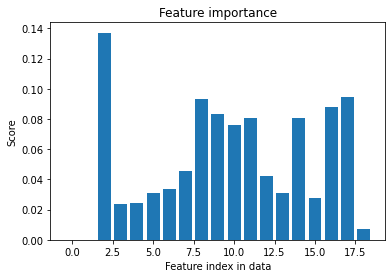

In [218]:
### using random forest to determine the relative feature importance

mess_importance_arr = RF_find_features(mess_df)

# plots the feature importance
plot_feature_importance(mess_importance_arr)

In [219]:
### finding the top 2 most important features to check values in correlation dataframe

top_2_features(mess_importance_arr, mess_df)

The most important feature is MA DETECTION CL 0.5
The second most important feature is OPTIC DISC DIAMATER


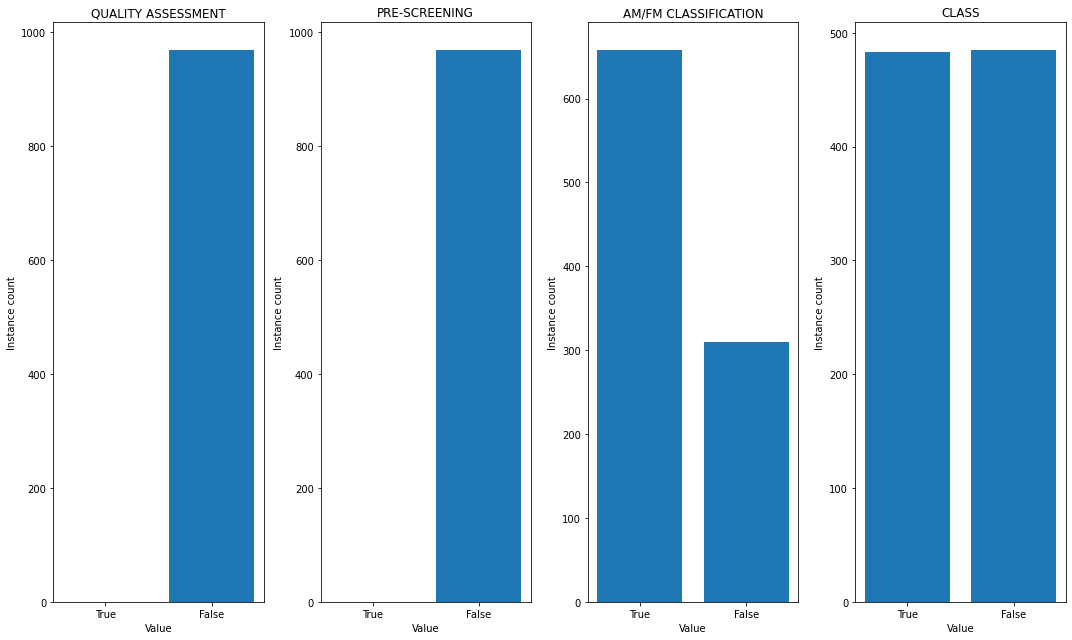

In [220]:
#### plotting a bar graph for each boolean column
plot_bool_distributions(mess_bool_cols, mess_df, 4)

# Implementing models

## Helper functions

In [221]:
### accuracy-evaluating function
def evaluate_acc(true_labels, target_labels):

  # the number of labels
  label_count = true_labels.shape[0]

  # the accuracy is the number of correctly labelled instances
  # divided by the total amount
  accuracy = np.sum(target_labels == true_labels)/label_count

  return accuracy

In [222]:
def run_KNN(x_train, x_test, y_train, y_test, df, K_val = 3):

  # creates a new KNN model
  knn_model = KNN(K = K_val)

  # fits the model to the training data, then tests the model on the test
  # data
  class_prob, knn_arr = knn_model.fit(x_train, y_train).predict(x_test)

  # outputs an array of the most likely class labels for each instance in x_test
  class_pred = np.argmax(class_prob, axis = -1)

  # finds the accuracy of the model
  accuracy = evaluate_acc(y_test, class_pred)

  # creates boolean arrays to represent correct and incorrect predictions
  correct_pred = class_pred == y_test
  incorrect_pred = np.logical_not(correct_pred)

  print("The accuracy of the model is: " + str(round((accuracy * 100), 2)) + "%")

  if x_train.shape[1] == 2:
    # creates boolean arrays to represent correct and incorrect predictions
    correct_pred = class_pred == y_test
    incorrect_pred = np.logical_not(correct_pred)

    plt.scatter(x_train[:, 0], x_train[:, 1], c = y_train, marker = 'o', alpha = 0.2, label = 'train')
    plt.scatter(x_test[correct_pred, 0], x_test[correct_pred, 1], marker = '.', c = class_pred[correct_pred], label = 'correct')
    plt.scatter(x_test[incorrect_pred, 0], x_test[incorrect_pred, 1], marker = 'x', c = class_pred[incorrect_pred], label = 'misclassified')

    for i in range(x_test.shape[0]):
      for k in range(knn_model.K):

        hor = x_test[i, 0], x_train[knn_arr[i, k], 0]
        ver = x_test[i, 1], x_train[knn_arr[i, k], 1]

        plt.plot(hor, ver, 'k-', alpha = 0.1)

    plt.xlabel(list(df)[0])
    plt.ylabel(list(df)[1])
    plt.legend()
    plt.show()

## KNN

In [223]:
# distance functions
euclidean = lambda x_train, x_test: np.sqrt(np.sum((x_train - x_test)**2, axis = -1))
manhattan = lambda x_train, x_test: np.sum(np.abs(x_train - x_test), axis = -1)
cosine = lambda x_train, x_test: np.sum(x_train * x_test, axis = -1) / ((np.sqrt(np.sum(x_train**2, axis = -1))) *(np.sqrt(np.sum(x_test**2, axis = -1))))

class KNN:
  # constructor
  def __init__(self, K = 1, dist_fn = euclidean):
    self.dist_fn = dist_fn
    self.K = K

  def fit(self, x_train, y_train):
    # stores the training data, since KNN is a lazy learner
    self.x_train = x_train
    self.y_train = y_train

    # the number of classes
    self.class_count = len(set(y_train))
    return self

  def predict(self, x_test):
    # uses the stored training data and x_test (test data passed as input)

    # the number of instances in the testing data
    instance_count = x_test.shape[0]

    # an array of the distances between the training data points and the testing
    # data points
    distances_arr = self.dist_fn(self.x_train[None, :, :], x_test[:, None, :])
    
    # initializes an array full of zeros for the k-nearest neighbours
    knn_arr = np.zeros((instance_count, self.K), dtype = int)
    # initializes an array full of zeros for the class probabilities
    class_prob = np.zeros((instance_count, self.class_count))

    # iterates through each instance in the testing data
    for instance in range(instance_count):
      # the i-th index is an array with the k-nearest neighbours in x_train to
      # data point i in x_test
      knn_arr[instance, :] = np.argsort(distances_arr[instance])[:self.K]
      
      # the i-th index is an array counting the occurrence of each
      # class type for data point i in x_test where the j-th index of the 
      # sub-array represents the number of neighbours in x_train of class j
      class_prob[instance, :] = np.bincount(self.y_train[knn_arr[instance,:]], minlength = self.class_count)
      #print(self.y_train[knn_arr[instance, :]].dtype)

    # divides all probabilities by the number of neighbours to look for
    class_prob /= self.K

    return class_prob, knn_arr


## Decision Tree

In [236]:
### cost functions

''' need to fix this
def misclassification_cost(labels):
  most_frequent_label = np.argmax(labels)
  cost = sum(1 for label in labels if label != most_frequent_label) / len(labels)
  return cost
''' 

def misclassification_cost(labels):
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    return 1 - np.max(class_probs)

def entropy_cost(labels):
  cost = 0
  unique_labels = set(labels)
  label_count = len(labels)

  for unique_label in unique_labels:
    cur_labels = sum(1 for label in labels if label == unique_label)
    ratio = cur_labels / label_count
    cost += ratio * np.log2(ratio)

  cost *= -1
  return cost

def gini_cost(labels):
  cost = 0
  unique_labels = set(labels)
  label_count = len(labels)

  for unique_label in unique_labels:
    cur_labels = sum(1 for label in labels if label == unique_label)
    ratio = cur_labels / label_count
    cost += np.square(ratio)

  cost = 1 - cost
  return cost         

# Running experiments

## KNN experiments

In [226]:
### running KNN on all hep_df data
run_KNN(x_train_hep, x_test_hep, y_train_hep, y_test_hep, hep_df)

The accuracy of the model is: 88.46%


In [227]:
### running KNN on all hep_df data cleaned through imputation
run_KNN(x_train_hep_imp, x_test_hep_imp, y_train_hep_imp, y_test_hep_imp, hep_imp_df)

The accuracy of the model is: 73.58%


The accuracy of the model is: 92.31%


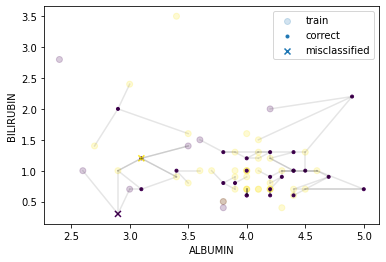

In [228]:
### running KNN on hep_df for top 2 features

# splits the hep_df dataframe to only include the columns with the top 2
# features and the target labels
hep_df2 = hep_df[['ALBUMIN', 'BILIRUBIN', 'CLASS']]

# runs train_test_split on the new dataframe
x_train_hep2, x_test_hep2, y_train_hep2, y_test_hep2 = train_test_split(hep_df2)

# runs KNN
run_KNN(x_train_hep2, x_test_hep2, y_train_hep2, y_test_hep2, hep_df2)

In [229]:
### running KNN on mess_df data
run_KNN(x_train_mess, x_test_mess, y_train_mess, y_test_mess, mess_df)

The accuracy of the model is: 62.73%


The accuracy of the model is: 57.27%


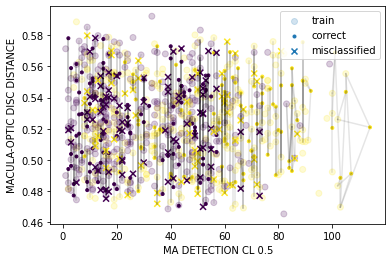

In [230]:
### running KNN on mess_df data for top 2 important features

# splits the hep_df dataframe to only include the columns with the top 2
# features and the target labels
mess_df2 = mess_df[['MA DETECTION CL 0.5', 'MACULA-OPTIC DISC DISTANCE', 'CLASS']]

# runs train_test_split on the new dataframe
x_train_mess2, x_test_mess2, y_train_mess2, y_test_mess2 = train_test_split(mess_df2)

# runs KNN
run_KNN(x_train_mess2, x_test_mess2, y_train_mess2, y_test_mess2, mess_df2)

The accuracy of the model is: 52.12%


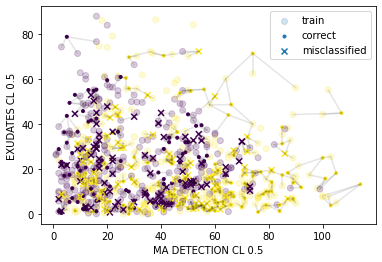

In [231]:
### running KNN on mess_df data for top 2 correlated features

# splits the hep_df dataframe to only include the columns with the top 2 correlated
# features and the target labels
mess_df2c = mess_df[['MA DETECTION CL 0.5', 'EXUDATES CL 0.5', 'CLASS']]

# runs train_test_split on the new dataframe
x_train_mess2c, x_test_mess2c, y_train_mess2c, y_test_mess2c = train_test_split(mess_df2c)

# runs KNN
run_KNN(x_train_mess2c, x_test_mess2c, y_train_mess2c, y_test_mess2c, mess_df2c)

## DT experiments